In [ ]:
# install 
# !apt update && apt install -y ffmpeg libsm6 libxext6

In [1]:
#Importing necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

plt.rcParams['figure.figsize'] = (10, 7)

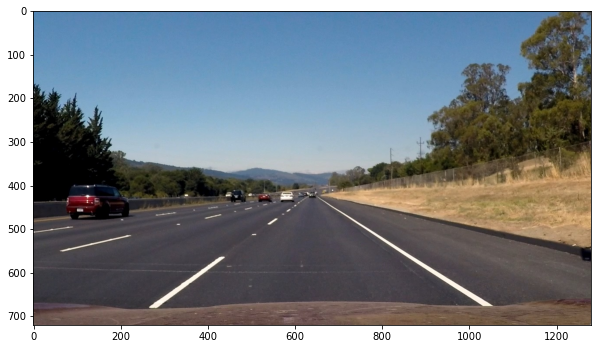

In [2]:
#Loading test image
image = cv2.imread("./test_images/straight_lines2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

In [28]:
#Defining function to reduce noise and detect edges
def canny_edge_detector(image): 
      
    # Convert the image color to grayscale 
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
      
    # Reduce noise from the image 
    blur = cv2.GaussianBlur(gray_image, (5, 5), 0)  
    canny = cv2.Canny(blur, 100, 150) 
    return canny 

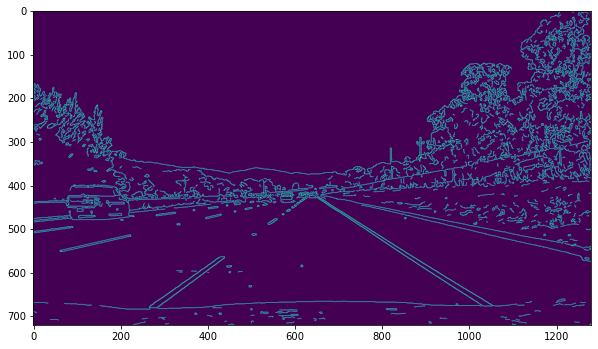

In [4]:
#Showing image with detected edges
canny_image = canny_edge_detector(image)
plt.imshow(canny_image);

In [15]:
# Specifying region of interest with a polygon on the image 
def region_of_interest(image): 
    height = image.shape[0] 
    width = image.shape[1]
    polygons = np.array([ 
        [(int(width*0.1), int(height*0.92)),
        (int(width/2), int(height*0.6)),
        (int(width*0.9), int(height*0.92))]
        ]) 
    
    mask = np.zeros_like(image) 
      
    # Fill poly-function deals with multiple polygon 
    cv2.fillPoly(mask, polygons, 255)  
      
    # Bitwise operation between canny image and mask image 
    masked_image = cv2.bitwise_and(image, mask)  
    return masked_image

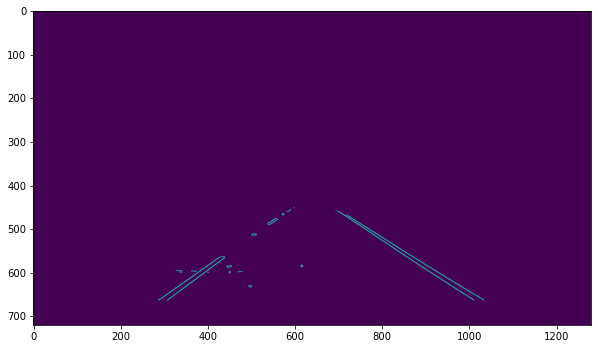

In [16]:
cropped_image = region_of_interest(canny_image)
plt.imshow(cropped_image);

In [17]:
def create_coordinates(image, line_parameters): 
    try:
        slope, intercept = line_parameters
    except TypeError:
        slope, intercept = 0.001, 0
    #slope, intercept = line_parameters 
    y1 = image.shape[0] 
    y2 = int(y1 * (3 / 5)) 
    x1 = int((y1 - intercept) / slope) 
    x2 = int((y2 - intercept) / slope) 
    return np.array([x1, y1, x2, y2])

In [22]:
def average_slope_intercept(image, lines): 
    left_fit = [] 
    right_fit = []
    if lines is not None:
        for line in lines: 
            x1, y1, x2, y2 = line.reshape(4) 

            # It will fit the polynomial and the intercept and slope 
            parameters = np.polyfit((x1, x2), (y1, y2), 1)  
            slope = parameters[0] 
            intercept = parameters[1] 
            if slope < 0: 
                left_fit.append((slope, intercept)) 
            else: 
                right_fit.append((slope, intercept)) 

    left_fit_average = np.average(left_fit, axis = 0) 
    right_fit_average = np.average(right_fit, axis = 0) 
    left_line = create_coordinates(image, left_fit_average) 
    right_line = create_coordinates(image, right_fit_average) 
    return np.array([left_line, right_line]) 

In [18]:
def display_lines(image, lines): 
    line_image = np.zeros_like(image) 
    if lines is not None:
        for line in lines: 
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10) 
    return line_image 

In [23]:
averaged_lines = average_slope_intercept(image, lines)

line_image = display_lines(image, averaged_lines)

combo_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)  

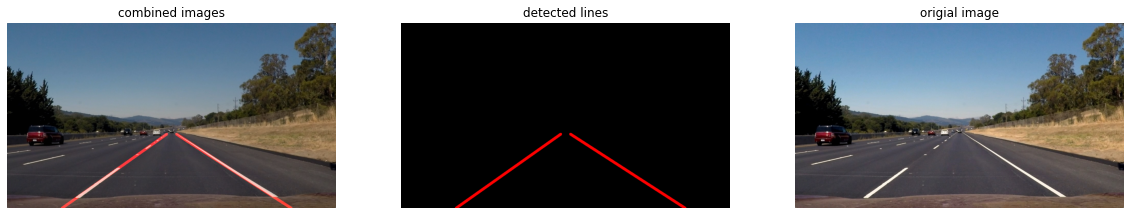

In [24]:
fig = plt.figure(figsize=(20, 13)) 
rows = 1
columns = 3
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
plt.imshow(combo_image) 
plt.axis('off') 
plt.title("combined images") 

# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 2) 
plt.imshow(line_image) 
plt.axis('off') 
plt.title("detected lines") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 3) 
plt.imshow(image) 
plt.axis('off') 
plt.title("origial image"); 

In [29]:
cap = cv2.VideoCapture("./videos/project_video.mp4")  
while(cap.isOpened()): 
    _, frame = cap.read() 
    if frame is not None:
        #cv2.imshow("original", frame)
        canny_image = canny_edge_detector(frame) 
        cropped_image = region_of_interest(canny_image) 
        cv2.imshow("cropped", cropped_image)
        lines = cv2.HoughLinesP(
                    image = cropped_image,
                    rho = 2,
                    theta = np.pi / 180,
                    threshold = 45, # 100
                    lines = np.array([]),
                    minLineLength = 40,  
                    maxLineGap = 100)  

        #averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(image, lines)
        combo_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)  
        cv2.imshow("results", combo_image) 

        # When the below two will be true and will press the 'q' on 
        # our keyboard, we will break out from the loop 

        # # wait 0 will wait for infinitely between each frames.  
        # 1ms will wait for the specified time only between each frames 
        if cv2.waitKey(30) & 0xFF == ord('q'):       
            break
    else:
        break

# close the video file 
cap.release()  
  
# destroy all the windows that is currently on 
cv2.destroyAllWindows()  
cv2.waitKey(1)

-1

In [ ]:
import cv2 as cv
import numpy as np
# import matplotlib.pyplot as plt

def do_canny(frame):
    # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    # Applies a 5x5 gaussian blur with deviation of 0 to frame - not mandatory since Canny will do this for us
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    # Applies Canny edge detector with minVal of 50 and maxVal of 150
    canny = cv.Canny(blur, 50, 150)
    return canny

def do_segment(frame):
    # Since an image is a multi-directional array containing the relative intensities of each pixel in the image, we can use frame.shape to return a tuple: [number of rows, number of columns, number of channels] of the dimensions of the frame
    # frame.shape[0] give us the number of rows of pixels the frame has. Since height begins from 0 at the top, the y-coordinate of the bottom of the frame is its height
    height = frame.shape[0]
    # Creates a triangular polygon for the mask defined by three (x, y) coordinates
    polygons = np.array([
                            [(0, height), (800, height), (380, 290)]
                        ])
    # Creates an image filled with zero intensities with the same dimensions as the frame
    mask = np.zeros_like(frame)
    # Allows the mask to be filled with values of 1 and the other areas to be filled with values of 0
    cv.fillPoly(mask, polygons, 255)
    # A bitwise and operation between the mask and frame keeps only the triangular area of the frame
    segment = cv.bitwise_and(frame, mask)
    return segment

def calculate_lines(frame, lines):
    # Empty arrays to store the coordinates of the left and right lines
    left = []
    right = []
    # Loops through every detected line
    for line in lines:
        # Reshapes line from 2D array to 1D array
        x1, y1, x2, y2 = line.reshape(4)
        # Fits a linear polynomial to the x and y coordinates and returns a vector of coefficients which describe the slope and y-intercept
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        y_intercept = parameters[1]
        # If slope is negative, the line is to the left of the lane, and otherwise, the line is to the right of the lane
        if slope < 0:
            left.append((slope, y_intercept))
        else:
            right.append((slope, y_intercept))
    # Averages out all the values for left and right into a single slope and y-intercept value for each line
    left_avg = np.average(left, axis = 0)
    right_avg = np.average(right, axis = 0)
    # Calculates the x1, y1, x2, y2 coordinates for the left and right lines
    left_line = calculate_coordinates(frame, left_avg)
    right_line = calculate_coordinates(frame, right_avg)
    return np.array([left_line, right_line])

def calculate_coordinates(frame, parameters):
    try:
        slope, intercept = parameters
    except TypeError:
        slope, intercept = 0,0
    #slope, intercept = parameters
    # Sets initial y-coordinate as height from top down (bottom of the frame)
    y1 = frame.shape[0]
    # Sets final y-coordinate as 150 above the bottom of the frame
    y2 = int(y1 - 150)
    # Sets initial x-coordinate as (y1 - b) / m since y1 = mx1 + b
    x1 = int((y1 - intercept) / slope)
    # Sets final x-coordinate as (y2 - b) / m since y2 = mx2 + b
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def visualize_lines(frame, lines):
    # Creates an image filled with zero intensities with the same dimensions as the frame
    lines_visualize = np.zeros_like(frame)
    # Checks if any lines are detected
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            # Draws lines between two coordinates with green color and 5 thickness
            cv.line(lines_visualize, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return lines_visualize

# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture("./videos/harder_challenge_video.mp4")

while (cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    canny = do_canny(frame)
    cv.imshow("canny", canny)
    # plt.imshow(frame)
    # plt.show()
    segment = do_segment(canny)
    hough = cv.HoughLinesP(segment, 2, np.pi / 180, 100, np.array([]), minLineLength = 100, maxLineGap = 50)
    # Averages multiple detected lines from hough into one line for left border of lane and one line for right border of lane
    lines = calculate_lines(frame, hough)
    # Visualizes the lines
    lines_visualize = visualize_lines(frame, lines)
    cv.imshow("hough", lines_visualize)
    # Overlays lines on frame by taking their weighted sums and adding an arbitrary scalar value of 1 as the gamma argument
    output = cv.addWeighted(frame, 0.9, lines_visualize, 1, 1)
    # Opens a new window and displays the output frame
    cv.imshow("output", output)
    # Frames are read by intervals of 10 milliseconds. The programs breaks out of the while loop when the user presses the 'q' key
    if cv.waitKey(10) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
cap.release()
cv.destroyAllWindows()